# "A typical Computer Vision problem: Part 2"
> "In this part of the series, I will be using machine learning to perform classification for the 12 classes we have."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [computer_vision, machine_learning, jupyter, ai]
- image: images/cv-2.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Part 2: Machine Learning

In Part 1, I explored the data that we're dealing with and performed some statistics on the number of images. I created and tested a helper function that will resize a given image to (128, 128). Finally I plotted the resized images along with their originals.

In this part, I will be using machine learning to perform classification for the 12 classes we have.

In [ ]:
import cv2 as cv
import os

## Preparing Features and Labels

An important step to classification problems is labeling the data. In our case, the images that belong to a given class are in the same directory. While looping over the images, I will add the corresponding label to the labels 'y'.
I will use OpenCV to deal with images. 
A helper function called **resize_to_128(img)** will be used to resize the images.
I will use another helper function called **prepare_features_labels()** to prepare the X vector that will hold the images and the corresponding label vector y that will hold the labels. 

In [ ]:
def resize_to_128(img):
    old_size = img.shape[:2]
    if old_size[0] == old_size[1]:
        img = cv.resize(img,(128, 128))
    else:
        ratio = float(128)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        img = cv.resize(img, (new_size[1], new_size[0]))
        delta_w = 128 - new_size[1]
        delta_h = 128 - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        img = cv.copyMakeBorder(img, top, bottom, left, right, cv.BORDER_CONSTANT, value=[255, 255, 255])
    return img

In [ ]:
def prepare_features_labels():
    X = []
    y = []
    directory = os.listdir('gear_images')
    for i, subdir in enumerate(sorted(directory)):
        subdirr = os.path.join('gear_images', subdir)
        for element in sorted(os.listdir(subdirr)):
            file_path = os.path.join(subdirr, element)
            X.append(resize_to_128(cv.imread(file_path)))
            y.append(i)
        print("Finished adding {}\'s images.".format(subdirr))
    return X, y

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving gear_images.zip to gear_images.zip


In [ ]:
import zipfile
with zipfile.ZipFile('gear_images.zip', 'r') as zip_ref:
    zip_ref.extractall()
# List the content of directory to verify if the files have been extracted
os.listdir()

['.config', 'gear_images', 'gear_images.zip', 'sample_data']

In [ ]:
X, y = prepare_features_labels()

Finished adding gear_images/axes's images.
Finished adding gear_images/boots's images.
Finished adding gear_images/carabiners's images.
Finished adding gear_images/crampons's images.
Finished adding gear_images/gloves's images.
Finished adding gear_images/hardshell_jackets's images.
Finished adding gear_images/harnesses's images.
Finished adding gear_images/helmets's images.
Finished adding gear_images/insulated_jackets's images.
Finished adding gear_images/pulleys's images.
Finished adding gear_images/rope's images.
Finished adding gear_images/tents's images.


## Feature Engineering

I will reshape the images by dividing the matrices by 255, since they consist of RGB layers and the maximum is 255. This step is called "**normalization**" and is always recommended. I will then perform one hot enconding of the labels.

### Applying Normalization

In [ ]:
for i in range(0,len(X)):
    X[i] = X[i]/255

### Performing one-hot-encoding

Using Scikit-Learn Label Encoder and One-Hot-Encoder, I will first fit and transform the label encoder to the labels columns **y** then fit and transform a one-hot-encoder to the result from the previous step. This way, we'll have our labels one-hot-encoded in matrix with 12 columns (the number of classes).

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
# Define a label encoder first
label_encoder = LabelEncoder()
# Fit the label encoder to
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

In [ ]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Splitting between training and test sets

As with any other type of machine learning, splitting the data that we have between training and test sets is an essential step. We need a test set that is not seen by the model while we train it so we can evaluate the model better. Using Scikit-Learn model selection module, I will split the data **80-20** meaning the test set will have roughly **20%** of the data.

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.2 ,random_state = 0)

print("Train: {}".format(len(X_train)))
print("Test: {}".format(len(X_test)))
print("Total: {}".format(len(X_test)+len(X_train)))

Train:  1697
Test:  425
Total:  2122


## Building the model Random Forests

I decided to use Random Forests for its proven good performance. After a few tries with the number of estimators, I chose **500**. The number of estimators is actually the number of trees in the forest. The default is **100**, however, since we expect a lot from this model and logically it must hold a lot of parameters to tackle a computer vision problem, it was expected to have way more than **100** estimators, which is in our case, **500**.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Transform the matrices into numpy arrays
X_train = np.asarray(X_train)

# Get the shape of X_train
nsamples, nx, ny, nz = X_train.shape

# Reshape X_train into an array of shape (nsamples, nx*ny*nz) since Random Forests requires this shape, i.e, it doesn't support tensors.
X_train_reshaped = X_train.reshape((nsamples,nx*ny*nz))

### Training the model

The first step is initializing a Random Forest Classifer with 500 trees in the forest then we can fit it to the **X_train_reshaped** array that we created from the earlier step. We also require the one-hot-encoded **y_train** matrice.

In [ ]:
clf = RandomForestClassifier(n_jobs=-1, random_state=7, max_features= 'auto', n_estimators=500)
clf.fit(X_train_reshaped, np.asarray(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

## Model Evaluation

A rule of thumb when evaluating the model on the test dataset is to apply the same feature engineering and processing on it. It's already normalized, I just need to reshape it. Using the **predict()** method of the trained classifier, we can get the predictions on the test dataset (**y_pred**).

In [ ]:
nsamples, nx, ny, nz = np.asarray(X_test).shape
X_test_reshaped = np.asarray(X_test).reshape((nsamples,nx*ny*nz))
y_pred = clf.predict(X_test_reshaped)

A helper function is defined below to plot the confusion matrix. A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

In [ ]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout(pad=3.0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Plotting the confusion matrix

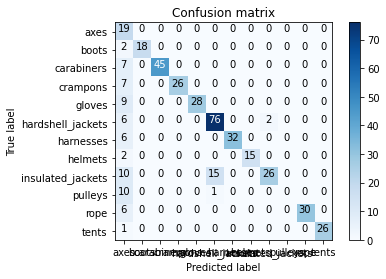

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['axes','boots','carabiners','crampons','gloves','hardshell_jackets','harnesses','helmets','insulated_jackets','pulleys','rope','tents']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### Performance Metrics

**F1 score**, **precision**, **recall** and **accuracy** are metrics that can be calculated and used to check the performance of a classifier. Accuracy alone doesn't reflect the real performance of a classifier; a model that has been trained on a unbalanced dataset **(90-10)**, will be **90%** accurate even if it always predicts the class to be the major one. The closer these metrics are to 1, the better the model is.

In [ ]:
print("F1 Score: {}".format(f1_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1), average="macro")))
print("Precision: {}".format(precision_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1), average="macro")))
print("Recall: {}".format(recall_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1), average="macro")))
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))))

F1 Score:  0.7706129493592867
Precision:  0.8315156497381562
Recall:  0.7704450405817796
Accuracy:  0.8023529411764706


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Data from the real world

The data that we used so far comes from one provider. In the real world, images might be different therefore it's always best to test the model on some data that is totally independant from the data that we have. For this reason, I searched for 5 images and put them in the directory 'testdata'. I will predict the classes and check the accuracy.

In [ ]:
class_names = ['axes','boots','carabiners','crampons','gloves','hardshell_jackets','harnesses','helmets','insulated_jackets','pulleys','rope','tents']
for image in os.listdir('testdata'):
    im = resize_to_128(cv.imread('testdata/'+image))/255
    pred = clf.predict(im.reshape(1,128*128*3))
    print(np.argmax(pred, axis=1))
    print(image)
    print(class_names[np.argmax(pred, axis=1)[0]])

[0]
axes.jpg
axes
[7]
helmets.jpg
helmets
[11]
tents.jpg
tents
[0]
insulated_jackets.jpg
axes
[2]
carabiners.jpg
carabiners


### Notes

1. The final accuracy is a little above 80%.
2. Out of the 5 test images used, 4 were correctly classified.
3. The number 0 on the diagonal of the confusion matrix that correspons to the pulleys class is due to the very small amount (24) of images compared to a few hundreds in each of the other class.

# Conclusion

In this part, I used Random Forests to classify the images. Results were fairly good (**80%+** accuracy) and an F1 score of **0.77**. However, for critical applications such as safety problems, we expect to have better metrics. In the next part, I will be using **Deep Learning** and specifically **Convolutional Neural Networks** to tackle this problem and hopefully get better results. Stay tuned and thank you for reading!